In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from matplotlib import gridspec
from IPython.display import Image
import theano.tensor as tt

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'


f_dict = {'size':16}

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Robust Linear Regression

### 30 individuals

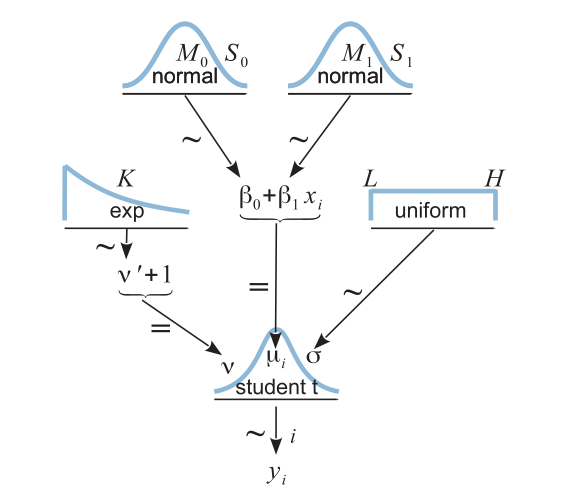

In [2]:
Image('images/robust_regression.png', width=400)

In [3]:
df_30 = pd.read_csv('../data/HtWtData30.csv')

In [4]:
df_30.head()

,male,height,weight
0,0,64.0,136.4
1,0,62.3,215.1
2,1,67.9,173.6
3,0,64.2,117.3
4,0,64.8,123.3


### Standardize the data

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
weight_scalar = StandardScaler()
height_scalar = StandardScaler()

In [7]:
df_30['zheight'] = height_scalar.fit_transform(df_30[['height']])

In [8]:
df_30['zweight'] = weight_scalar.fit_transform(df_30[['weight']])

In [9]:
with pm.Model() as model:
    beta_0 = pm.Normal('beta_0', mu=0, tau=1/100)
    beta_1 = pm.Normal('beta_1', mu=0, tau=1/100)
    mu = beta_0 + beta_1 * df_30.zheight.ravel()
    
    sigma = pm.Uniform('sigma', lower=0.001, upper=1000)
    nu = pm.Exponential('nu', 1/29.)
    
    likelihood = pm.StudentT('likelihood', nu, mu=mu, sd=sigma, observed=df_30.zweight)

In [12]:
from graphviz import Graph

In [13]:
g = Graph(format='png')
g.render()

'Graph.gv.png'

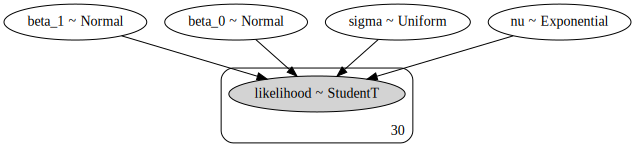

In [14]:
pm.model_to_graphviz(model)

In [15]:
with model:
    trace = pm.sample(draws=2000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [nu, sigma, beta_1, beta_0]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:12<00:00, 828.15draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb17c2a3eb8>,
      dtype=object)

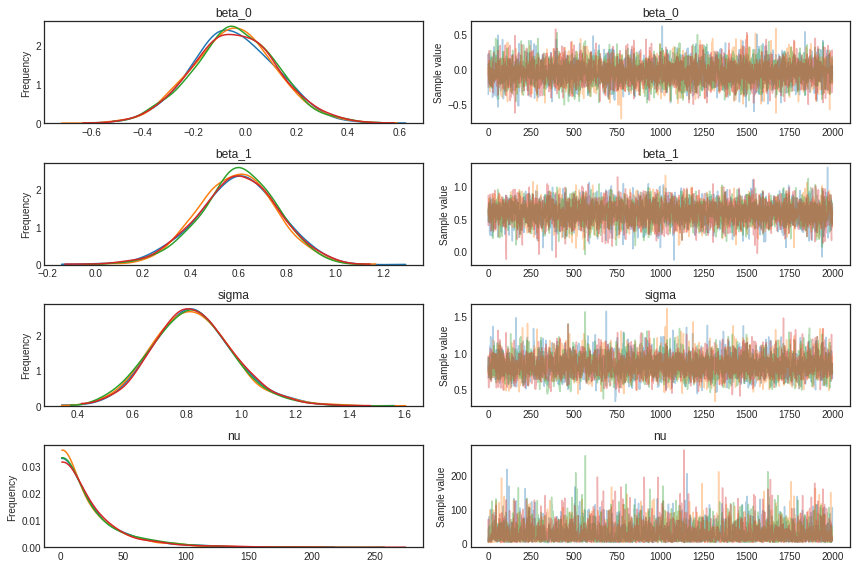

In [16]:
pm.traceplot(trace)

In [19]:
def plot_grid(trace, data, sd_h, sd_w, mean_h, mean_w):
    """This function creates plots like figures 17.3 and 17.4 in the book."""
    
    plt.figure(figsize=(13,13))
    
    # Define gridspec
    gs = gridspec.GridSpec(4, 6)
    ax1 = plt.subplot(gs[:2,1:5])
    ax2 = plt.subplot(gs[2,:2])
    ax3 = plt.subplot(gs[2,2:4])
    ax4 = plt.subplot(gs[2,4:6])
    ax5 = plt.subplot(gs[3,:2])
    ax6 = plt.subplot(gs[3,2:4])                     
    ax7 = plt.subplot(gs[3,4:6])
        
    # Scatter plot of the observed data
    ax1.scatter(data.height, data.weight, s=40, linewidths=1, facecolor='none', edgecolor='k', zorder=10)
    ax1.set_xlabel('height', fontdict=f_dict)
    ax1.set_ylabel('height', fontdict=f_dict)
    ax1.set(xlim=(0,80), ylim=(-350,250))

    # Convert parameters to original scale
    beta0 = trace['beta_0']*sd_w+mean_w-trace['beta_1']*mean_h*sd_w/sd_h
    beta1 = trace['beta_1']*(sd_w/sd_h)
    sigma = trace['sigma']*sd_w
    B = pd.DataFrame(np.c_[beta0, beta1], columns=['beta0', 'beta1'])
       
    # Credible regression lines from posterior
    hpd_interval = np.round(pm.hpd(B.values, alpha=0.05), decimals=3)
    B_hpd = B[B.beta0.between(*hpd_interval[0,:]) & B.beta1.between(*hpd_interval[1,:])] 
    xrange = np.arange(0, data.height.max()*1.05)
    for i in np.random.randint(0, len(B_hpd), 30):
        ax1.plot(xrange, B_hpd.iloc[i,0]+B_hpd.iloc[i,1]*xrange, c=color, alpha=.6, zorder=0)    
        
    # Intercept
    pm.plot_posterior(beta0, point_estimate='mode', ax=ax2, color=color)
    ax2.set_xlabel(r'$\beta_0$', fontdict=f_dict)
    ax2.set_title('Intercept', fontdict={'weight':'bold'})

    # Slope
    pm.plot_posterior(beta1, point_estimate='mode', ax=ax3, color=color, ref_val=0)
    ax3.set_xlabel(r'$\beta_1$', fontdict=f_dict)
    ax3.set_title('Slope', fontdict={'weight':'bold'})
    
    # Scatter plot beta1, beta0
    ax4.scatter(beta1, beta0, edgecolor=color, facecolor='none', alpha=.6)
    ax4.set_xlabel(r'$\beta_1$', fontdict=f_dict)
    ax4.set_ylabel(r'$\beta_0$', fontdict=f_dict)
    
    # Scale
    pm.plot_posterior(sigma, point_estimate='mode', ax=ax5, color=color)
    ax5.set_xlabel(r'$\sigma$', fontdict=f_dict)
    ax5.set_title('Scale', fontdict={'weight':'bold'})

    # Normality
    pm.plot_posterior(np.log10(trace['nu']), point_estimate='mode', ax=ax6, color=color)
    ax6.set_xlabel(r'log10($\nu$)', fontdict=f_dict)
    ax6.set_title('Normality', fontdict={'weight':'bold'})
    
    # Scatter plot normality, sigma
    ax7.scatter(np.log10(trace['nu']), sigma,
                edgecolor=color, facecolor='none', alpha=.6)
    ax7.set_xlabel(r'log10($\nu$)', fontdict=f_dict)
    ax7.set_ylabel(r'$\sigma$', fontdict=f_dict)
    
    plt.tight_layout()
    
    return(plt.gcf());

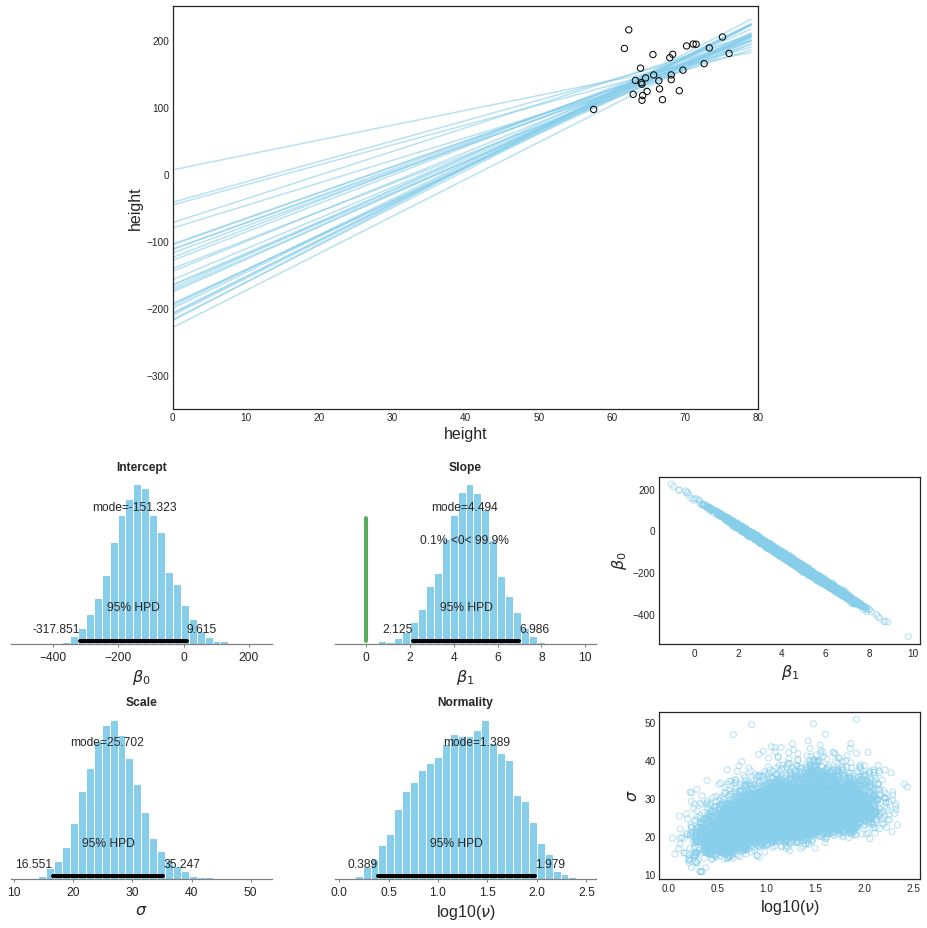

In [20]:
plot_grid(trace, df_30, df_30.height.std(), df_30.weight.std(), df_30.height.mean(), df_30.weight.mean());

### 300 individuals

In [21]:
df_300 = pd.read_csv('../data/HtWtData300.csv')

In [22]:
df_300.head()

,male,height,weight
0,0,64.0,136.4
1,0,62.3,215.1
2,1,67.9,173.6
3,0,64.2,117.3
4,0,64.8,123.3


### Standardize the data

In [25]:
from sklearn.preprocessing import StandardScaler

In [26]:
weight_scalar = StandardScaler()
height_scalar = StandardScaler()

In [27]:
df_300['zheight'] = height_scalar.fit_transform(df_300[['height']])

In [28]:
df_300['zweight'] = weight_scalar.fit_transform(df_300[['weight']])

In [37]:
with pm.Model() as model:
    beta_0 = pm.Normal('beta_0', mu=0, tau=1/100)
    beta_1 = pm.Normal('beta_1', mu=0, tau=1/100)
    mu = beta_0 + beta_1 * df_300.zheight.ravel()
    
    sigma = pm.Uniform('sigma', lower=0.001, upper=1000)
    nu = pm.Exponential('nu', 1/299.)
    
    likelihood = pm.StudentT('likelihood', nu, mu=mu, sd=sigma, observed=df_300.zweight)

In [38]:
from graphviz import Graph

In [39]:
g = Graph(format='png')
g.render()

'Graph.gv.png'

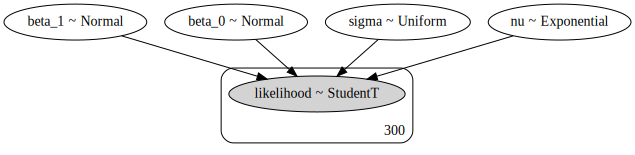

In [40]:
pm.model_to_graphviz(model)

In [41]:
with model:
    trace = pm.sample(draws=2000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [nu, sigma, beta_1, beta_0]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:11<00:00, 839.43draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb174306710>,
      dtype=object)

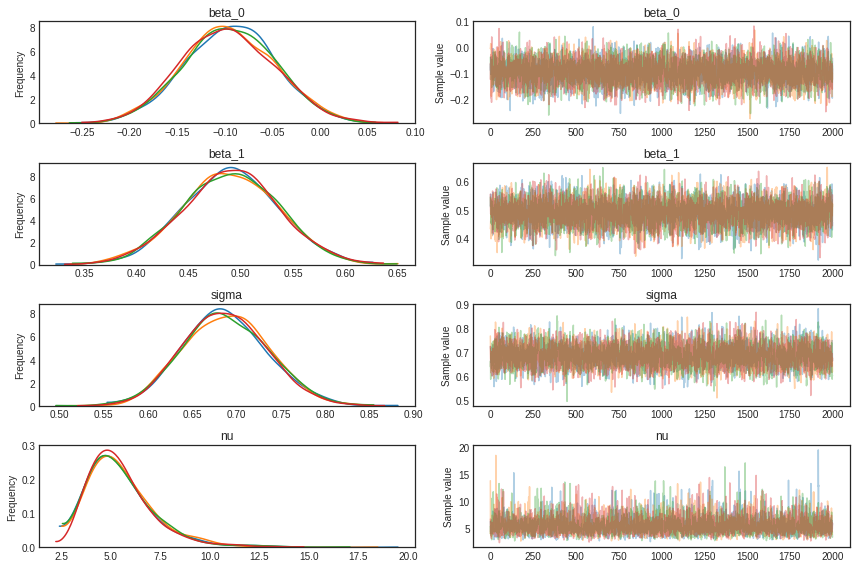

In [42]:
pm.traceplot(trace)

In [43]:
def plot_grid(trace, data, sd_h, sd_w, mean_h, mean_w):
    """This function creates plots like figures 17.3 and 17.4 in the book."""
    
    plt.figure(figsize=(13,13))
    
    # Define gridspec
    gs = gridspec.GridSpec(4, 6)
    ax1 = plt.subplot(gs[:2,1:5])
    ax2 = plt.subplot(gs[2,:2])
    ax3 = plt.subplot(gs[2,2:4])
    ax4 = plt.subplot(gs[2,4:6])
    ax5 = plt.subplot(gs[3,:2])
    ax6 = plt.subplot(gs[3,2:4])                     
    ax7 = plt.subplot(gs[3,4:6])
        
    # Scatter plot of the observed data
    ax1.scatter(data.height, data.weight, s=40, linewidths=1, facecolor='none', edgecolor='k', zorder=10)
    ax1.set_xlabel('height', fontdict=f_dict)
    ax1.set_ylabel('height', fontdict=f_dict)
    ax1.set(xlim=(0,80), ylim=(-350,250))

    # Convert parameters to original scale
    beta0 = trace['beta_0']*sd_w+mean_w-trace['beta_1']*mean_h*sd_w/sd_h
    beta1 = trace['beta_1']*(sd_w/sd_h)
    sigma = trace['sigma']*sd_w
    B = pd.DataFrame(np.c_[beta0, beta1], columns=['beta0', 'beta1'])
       
    # Credible regression lines from posterior
    hpd_interval = np.round(pm.hpd(B.values, alpha=0.05), decimals=3)
    B_hpd = B[B.beta0.between(*hpd_interval[0,:]) & B.beta1.between(*hpd_interval[1,:])] 
    xrange = np.arange(0, data.height.max()*1.05)
    for i in np.random.randint(0, len(B_hpd), 30):
        ax1.plot(xrange, B_hpd.iloc[i,0]+B_hpd.iloc[i,1]*xrange, c=color, alpha=.6, zorder=0)    
        
    # Intercept
    pm.plot_posterior(beta0, point_estimate='mode', ax=ax2, color=color)
    ax2.set_xlabel(r'$\beta_0$', fontdict=f_dict)
    ax2.set_title('Intercept', fontdict={'weight':'bold'})

    # Slope
    pm.plot_posterior(beta1, point_estimate='mode', ax=ax3, color=color, ref_val=0)
    ax3.set_xlabel(r'$\beta_1$', fontdict=f_dict)
    ax3.set_title('Slope', fontdict={'weight':'bold'})
    
    # Scatter plot beta1, beta0
    ax4.scatter(beta1, beta0, edgecolor=color, facecolor='none', alpha=.6)
    ax4.set_xlabel(r'$\beta_1$', fontdict=f_dict)
    ax4.set_ylabel(r'$\beta_0$', fontdict=f_dict)
    
    # Scale
    pm.plot_posterior(sigma, point_estimate='mode', ax=ax5, color=color)
    ax5.set_xlabel(r'$\sigma$', fontdict=f_dict)
    ax5.set_title('Scale', fontdict={'weight':'bold'})

    # Normality
    pm.plot_posterior(np.log10(trace['nu']), point_estimate='mode', ax=ax6, color=color)
    ax6.set_xlabel(r'log10($\nu$)', fontdict=f_dict)
    ax6.set_title('Normality', fontdict={'weight':'bold'})
    
    # Scatter plot normality, sigma
    ax7.scatter(np.log10(trace['nu']), sigma,
                edgecolor=color, facecolor='none', alpha=.6)
    ax7.set_xlabel(r'log10($\nu$)', fontdict=f_dict)
    ax7.set_ylabel(r'$\sigma$', fontdict=f_dict)
    
    plt.tight_layout()
    
    return(plt.gcf());

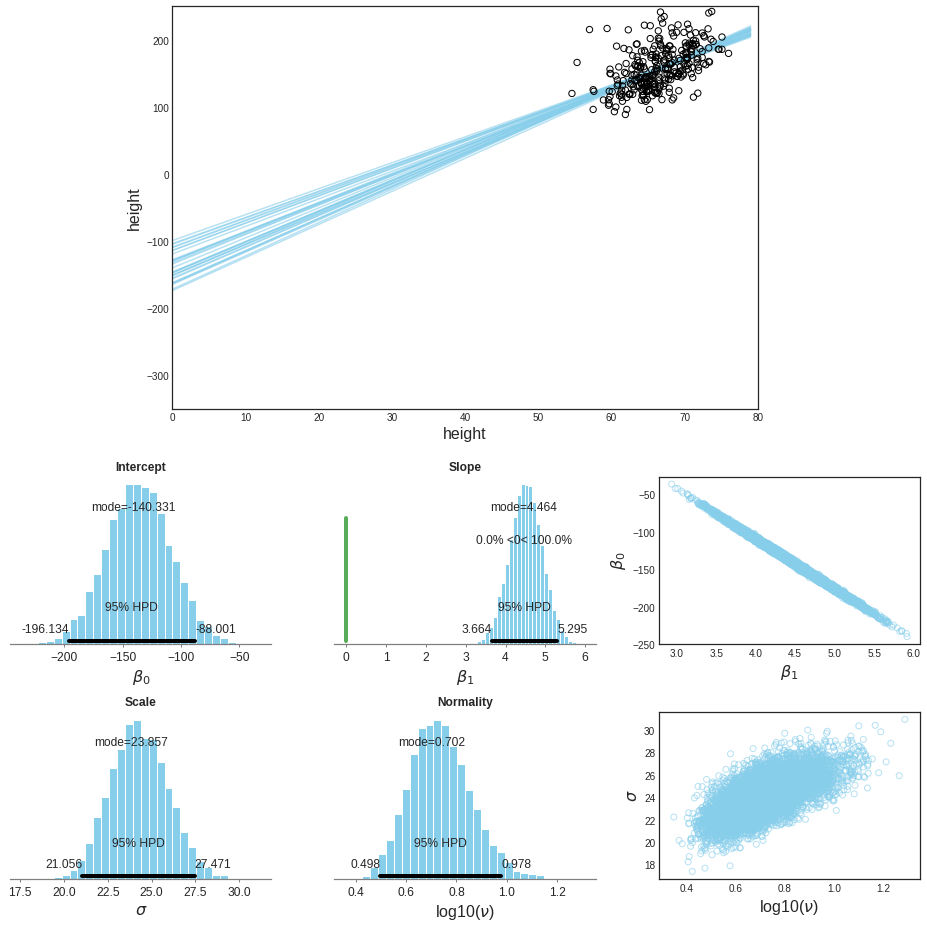

In [44]:
plot_grid(trace, df_300, df_300.height.std(), df_300.weight.std(), df_300.height.mean(), df_300.weight.mean());

## Robust Hierachical Linear Regression

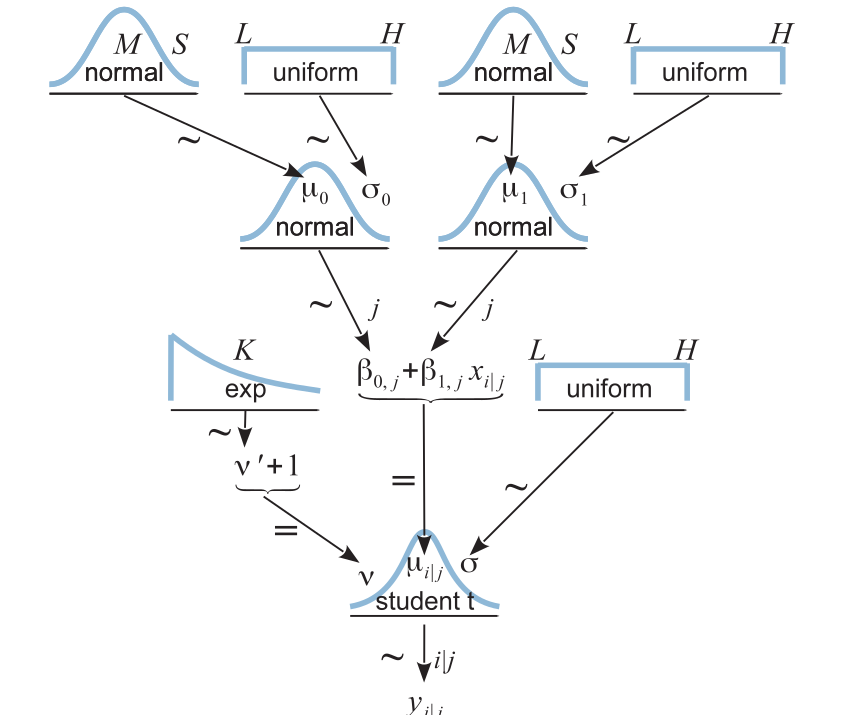

In [45]:
Image('./images/robust_hierachical_linear_regression.png')

In [48]:
df = pd.read_csv('../data/HierLinRegressData.csv')

In [50]:
df.Subj = pd.Categorical(df.Subj)

In [51]:
subject_idx = df.Subj.cat.codes.values

In [53]:
subject_codes = df.Subj.cat.categories

In [62]:
n_subj = df.Subj.nunique()

In [47]:
df.head()

,Subj,X,Y
0,1,60.2,145.6
1,1,61.5,157.3
2,1,61.7,165.6
3,1,62.3,158.8
4,1,67.6,196.1


In [56]:
weight_scalar = StandardScaler()
height_scalar = StandardScaler()

df['zx'] = height_scalar.fit_transform(df[['X']])
df['zy'] = weight_scalar.fit_transform(df[['Y']])

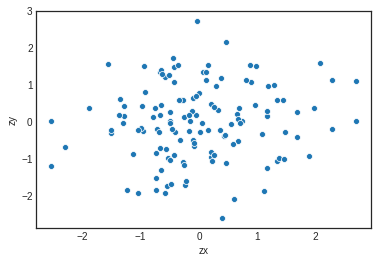

In [60]:
sns.scatterplot(df['zx'], df['zy'])

In [68]:
with pm.Model() as model:
    mu_0 = pm.Normal('mu_0')
    sigma_0 = pm.Uniform('sigma_0')
    mu_1 = pm.Normal('mu_1')
    sigma_1 = pm.Uniform('sigma_1')
    
    beta_0 = pm.Normal('beta_0', mu=mu_0, sd=sigma_0, shape=n_subj)
    beta_1 = pm.Normal('beta_1', mu=mu_1, sd=sigma_1, shape=n_subj)
    
    nu = pm.Exponential('nu', 1/29.)
    mu = beta_0[subject_idx] + beta_1[subject_idx] * df.zx
    sigma = pm.Uniform('sigma')
    
    likelihood = pm.StudentT('likelihood', nu, mu=mu, sd=sigma, observed=df.zy, shape=n_subj)

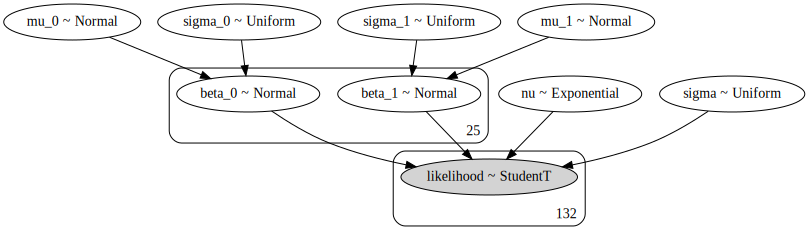

In [69]:
pm.model_to_graphviz(model)